<a href="https://colab.research.google.com/github/PratikshitSingh/A-ESRGANs/blob/main/444%20dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install basicsr

In [ ]:
import os, random
import numpy as np
import torch
from basicsr.data.degradations import random_add_gaussian_noise_pt, random_add_poisson_noise_pt
from basicsr.data.transforms import paired_random_crop
from basicsr.models.srgan_model import SRGANModel
from basicsr.utils import DiffJPEG, USMSharp
from basicsr.utils.img_process_util import filter2D
from basicsr.utils.registry import MODEL_REGISTRY
from torchvision.transforms import GaussianBlur
from PIL import ImageFile, Image
from torch.utils import data
from torch.nn import functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
data_path = "stitched_images.jpg"

In [ ]:
def get_all_file(target_dir,subfix=None, img=True): # just for this project
  g = os.walk(target_dir)
  data = []
  for path,dir_list,file_list in sorted(g):
    data += sorted(file_list)
  if img:
    data = [os.path.join(target_dir,i.split("_")[0],i) for i in data]
  else:
    data = [os.path.join(target_dir,i) for i in data]
  if subfix != None:
    data = [i for i in data if i.endswith(subfix)]
  return data

In [ ]:
class LoadData(data.Dataset):

  def __init__(self,split="train",preload=True, data_dir=data_path, num_data=None, image=None):
    assert(split in ["train","val","test"])
    # if split == "train":
    #   self.img_dir = os.path.join(img_dir,type_2)
    #   self.data_dir = os.path.join(data_dir,data_type)
    # else:
    #   self.img_dir = os.path.join(img_dir,split,type_2)
    #   self.data_dir = os.path.join(data_dir,split,data_type)
    # print(self.img_dir)
    # print(self.data_dir)

    # self.split = split
    # self.data = get_all_file(self.img_dir,subfix="png", img= type_2 == "")
    # self.mask_data = get_all_file(self.data_dir,subfix="png", img=False)

    #insert dataloading here
    self.img = image #temp testing var
    self.data=data_path
    self.preload = preload
    self.usm_sharpener = USMSharp()
    self.jpeger = DiffJPEG(differentiable=False)
    self.blurrer = GaussianBlur(25)

    if preload:
      self.images = list(map(Image.open, self.data[:num_data]))
      
  def __len__(self):
    return len(self.images)
  
  def transform(self, img):
    print(img.size())
    ori_h, ori_w = img.size()[1:]
    img = img.unsqueeze(0).float()
    print(img.dtype)
    img_usm = self.usm_sharpener(img)
    degen = self.blurrer(img_usm.clone())
    gauss_noise_prob = 0.5
    resize_range1 = 0.5
    resize_range2 = 0.25
    sigma_range = (1, 30)
    pscale = (0.05, 3)

    updown_type = random.choices(['up', 'down', 'keep'])[0]
    if updown_type == 'up':
        scale = np.random.uniform(1, 1 + resize_range1)
    elif updown_type == 'down':
        scale = np.random.uniform(1 - resize_range1, 1)
    else:
        scale = 1

    mode = random.choice(['area', 'bilinear', 'bicubic'])
    out = F.interpolate(degen, scale_factor=scale, mode=mode)

    gray_noise_prob = 0.33
    if np.random.uniform() < gauss_noise_prob:
        out = random_add_gaussian_noise_pt(
            out,
            sigma_range=sigma_range, 
            clip=True, 
            rounds=False, 
            gray_prob=gray_noise_prob)
    else:
        out = random_add_poisson_noise_pt(
            out,
            scale_range=pscale,
            gray_prob=gray_noise_prob,
            clip=True,
            rounds=False)
    # JPEG compression
    jpeg_p = out.new_zeros(out.size(0)).uniform_(30, 95)
    out = torch.clamp(out, 0, 1)
    out = self.jpeger(out, quality=jpeg_p)

    blur2_prob = 0.333
    if np.random.uniform() < blur2_prob:
        out = self.blurrer(out)
    # random resize
    updown_type = random.choices(['up', 'down', 'keep'])[0]
    if updown_type == 'up':
        scale = np.random.uniform(1, 1 + resize_range2)
    elif updown_type == 'down':
        scale = np.random.uniform(1 - resize_range2, 1)
    else:
        scale = 1
    mode = random.choice(['area', 'bilinear', 'bicubic'])
    scale_opt = 4
    out = F.interpolate(
        out, size=(int(ori_h / scale_opt * scale), int(ori_w / scale_opt * scale)), mode=mode)
    # noise
    if np.random.uniform() < gauss_noise_prob:
        out = random_add_gaussian_noise_pt(
            out, 
            sigma_range=sigma_range, 
            clip=True, 
            rounds=False, 
            gray_prob=gray_noise_prob)
    else:
        out = random_add_poisson_noise_pt(
            out,
            scale_range=pscale,
            gray_prob=gray_noise_prob,
            clip=True,
            rounds=False)

    mode = random.choice(['area', 'bilinear', 'bicubic'])
    out = F.interpolate(out, size=(ori_h // scale_opt, ori_w // scale_opt), mode=mode)

    jpeg_p = out.new_zeros(out.size(0)).uniform_(30, 95)
    out = torch.clamp(out, 0, 1)
    out = self.jpeger(out, quality=jpeg_p)
    return img_usm, out

  def __getitem__(self,idx):
    # if self.preload:
    #   img = self.images[idx]
    # else:
    #   img = Image.open(self.img_data[idx])
    img = Image.open(self.img)
    
    tens = transforms.Compose([transforms.PILToTensor()])
    img = tens(img)


    seed = np.random.randint(1000000000)

    gt, out = self.transform(img)

    if len(np.array(img).shape) == 3:
      ret_image = torch.permute(torch.tensor(np.array(img)), (2, 0, 1))
    else:
      ret_image = torch.tensor(np.array(img))
    return gt, out

In [ ]:
dataaset = LoadData(image=data_path, preload=False)

In [ ]:
gt, out = dataaset[0]

torch.Size([3, 756, 3037])
torch.float32


torch.Size([1, 3, 189, 759])


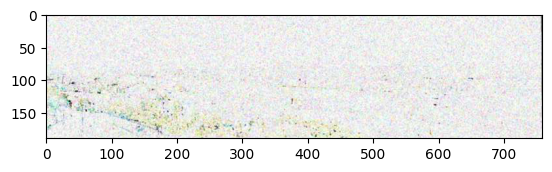

In [ ]:
print(out.size())
out = out.squeeze().permute(1, 2, 0)
plt.imshow(out.detach().numpy())